In [107]:
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error
from xgboost import XGBRegressor, plot_tree


In [108]:
# Initialize dictionary of dataframes

adv_pass = {}
data = {}
years = [19, 20, 21, 22, 23, 24]


In [109]:
# Load CSVs per year

# NOTE: You can comment out a line if you already have the data and don't want to import it
for x in years:
    adv_pass[x] = pd.read_csv('data/passing_adv_20' + str(x) + '.csv')

print("done")


done


In [110]:
adv_pass[23].columns

Index(['name_display', 'age', 'team_name_abbr', 'pos', 'games',
       'games_started', 'pass_cmp', 'pass_att', 'pass_target_yds',
       'pass_tgt_yds_per_att', 'pass_air_yds', 'pass_air_yds_per_cmp',
       'pass_air_yds_per_att', 'pass_yac', 'pass_yac_per_cmp',
       'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 'pass_drops',
       'pass_drop_pct', 'pass_poor_throws', 'pass_poor_throw_pct',
       'pass_on_target', 'pass_on_target_pct', 'pocket_time', 'pass_blitzed',
       'pass_hurried', 'pass_hits', 'pass_pressured', 'pass_pressured_pct',
       'rush_scrambles', 'rush_scrambles_yds_per_att', 'pass_rpo',
       'pass_rpo_yds', 'pass_rpo_pass_att', 'pass_rpo_pass_yds',
       'pass_rpo_rush_att', 'pass_rpo_rush_yds', 'pass_play_action',
       'pass_play_action_pass_yds'],
      dtype='object')

In [111]:
# Extract subsets of columns we want from CSVs into dataframes we will use for calculations

# TODO: rename these columns (e.g. 'name_display' to 'player', 'team_name_abbr' to 'tm', 'pass_cmp' to 'cmp', etc.)
for x in years:
    df = adv_pass[x]
    df = df[df['pass_att'] >= 250] # Drop passers who don't have at least 250 pass attempts
    data[x] = df[['name_display', 'team_name_abbr', 'pass_cmp', 'pass_att', 'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 
                        'pass_drops', 'pass_poor_throws','pass_on_target', 'pocket_time', 'pass_blitzed', 'pass_hurried',
                        'pass_hits', 'pass_pressured', 'rush_scrambles', 
                        'pass_drop_pct', 'pass_poor_throw_pct', 'pass_on_target_pct', 'pass_pressured_pct']]
    


In [112]:
# Color Palette
# Map each team to its respective hex color

nfl_team_colors = {
    'ARI': '#97233F',  # Arizona Cardinals
    'ATL': '#A71930',  # Atlanta Falcons
    'BAL': '#241773',  # Baltimore Ravens
    'BUF': '#00338D',  # Buffalo Bills
    'CAR': '#0085CA',  # Carolina Panthers
    'CHI': '#0B162A',  # Chicago Bears
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'CLE': '#311D00',  # Cleveland Browns
    'DAL': '#003594',  # Dallas Cowboys
    'DEN': '#FB4F14',  # Denver Broncos
    'DET': '#0076B6',  # Detroit Lions
    'GNB':  '#203731',  # Green Bay Packers
    'HOU': '#03202F',  # Houston Texans
    'IND': '#002C5F',  # Indianapolis Colts
    'JAX': '#006778',  # Jacksonville Jaguars
    'KAN':  '#E31837',  # Kansas City Chiefs
    'LAC': '#0073CF',  # Los Angeles Chargers
    'LAR': '#003594',  # Los Angeles Rams
    'LVR':  '#000000',  # Las Vegas Raiders
    'MIA': '#008E97',  # Miami Dolphins
    'MIN': '#4F2683',  # Minnesota Vikings
    'NWE':  '#002244',  # New England Patriots
    'NOR':  '#D3BC8D',  # New Orleans Saints
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
    'OAK' : '000000', # Oakland Raiders
    'PHI': '#004C54',  # Philadelphia Eagles
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'SEA': '#002244',  # Seattle Seahawks
    'SFO':  '#AA0000',  # San Francisco 49ers
    'TAM':  '#D50A0A',  # Tampa Bay Buccaneers
    'TEN': '#4B92DB',  # Tennessee Titans
    'WAS': '#5A1414'   # Washington Commanders
}


In [113]:
# Function which can graph any singular stat for any given dataframe

def statGrapher(df, stat, text = 'Stat', yr = 2024, pct = True):
    
    # Plot data by descending order of stat leader
    order_stat = df.sort_values(by=stat, ascending=False)['name_display']
    stat_ranked = df.sort_values(by=stat, ascending=False)[stat]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=stat, y='name_display', hue = 'team_name_abbr', data=df, 
                palette = nfl_team_colors, order = order_stat, dodge = False)
    
    plt.title(text + " in " + str(yr))
    plt.legend().remove()
    
    # Set x-axis and y-axis labels
    plt.xlabel(text)  # x-axis label
    plt.ylabel('Quarterback')  # y-axis label
    
    # Show actual stat on plot
    i = 0
    for x in stat_ranked.astype(float):
        if pct:
            plt.text(x, i, f"{x:.2f}" + "%", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        else:
             plt.text(x, i, f"{x:.2f}", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        i += 1
        
    center_position = (df.index.max() + df.index.min()) / 2

    # Add a horizontal line along the center
    plt.axhline(y = center_position, color='r', linestyle='--', linewidth=2)
    
    plt.show()


In [114]:
# Calcuate eval metrics based on given data

def calcEval(y, pred):
    r2 = r2_score(y, pred)
    print(f"R²: {r2}")

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, pred)
    print(f"Mean Absolute Error (MAE): {mae}")

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

In [115]:
# Consolildate year-by-year data into one big df (i.e. xCmp_data) and also include a season column

xCmp_data = pd.DataFrame()
xCmpPct_data = pd.DataFrame()

for x in years:
    df = data[x]
    df['Season'] = "20" + str(x)
    xCmp_data = pd.concat([xCmp_data, df], axis=0)
    xCmpPct_data = pd.concat([xCmpOL_data, df], axis=0)

xCmp_data['cmpPct'] = (xCmp_data['pass_cmp']/xCmp_data['pass_att']) * 100
xCmp_data['xAtt'] = xCmpOL_data['pass_att'] - xCmpOL_data['pass_spikes']

xCmpPct_data['cmpPct'] = (xCmpPct_data['pass_cmp']/xCmpPct_data['pass_att']) * 100
xCmpPct_data['xAtt'] = xCmpPct_data['pass_att'] - xCmpPct_data['pass_spikes']

# xCmpPct Model using XGB

In [148]:
# Create X and y

X = xCmpPct_data[['pass_throwaways', 'pass_poor_throw_pct', 'pass_on_target_pct', 'pass_drop_pct']]
y = xCmpPct_data[['cmpPct']]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [150]:
# create xgb model

xgbCmpPct_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)



In [151]:
xgbCmpPct_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [152]:
# Get predictions
y_pred = xgbCmpPct_model.predict(X_test)

y_train_pred = xgbCmpPct_model.predict(X_train)

In [153]:
# Evaluation Metrics for TESTING data

calcEval(y_test, y_pred)


R²: 0.8523728847503662
Mean Absolute Error (MAE): 1.1456233263015747
Mean Squared Error (MSE): 1.9582923650741577
Root Mean Squared Error (RMSE): 1.3993899974896769


In [154]:
# Evaluation Metrics for TRAINING data

calcEval(y_train, y_train_pred)

R²: 0.9343665838241577
Mean Absolute Error (MAE): 0.7101024389266968
Mean Squared Error (MSE): 0.867351770401001
Root Mean Squared Error (RMSE): 0.9313172232923651


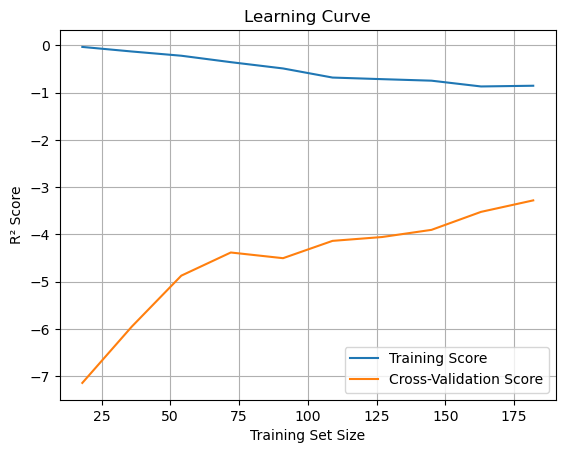

In [155]:
train_sizes, train_scores, test_scores = learning_curve(
    xgbCmpPct_model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()

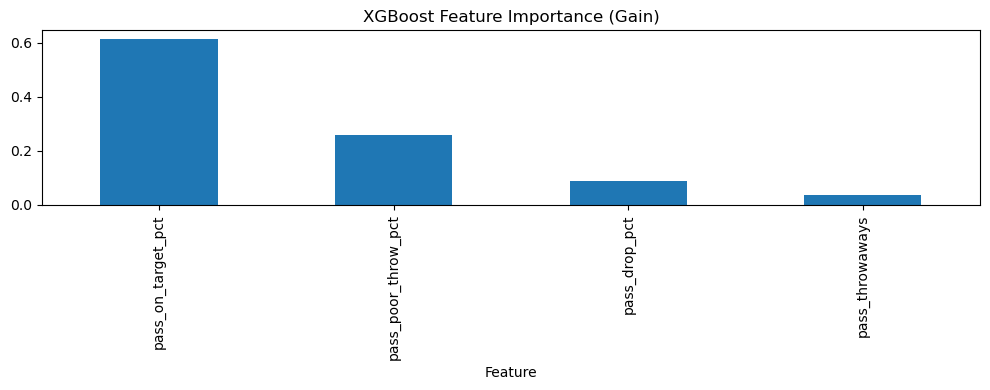

In [156]:
# Plot feature importance

importance = xgbCmpPct_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
importance_df.plot.bar(x='Feature', y='Importance', legend=False, figsize=(10, 4))
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

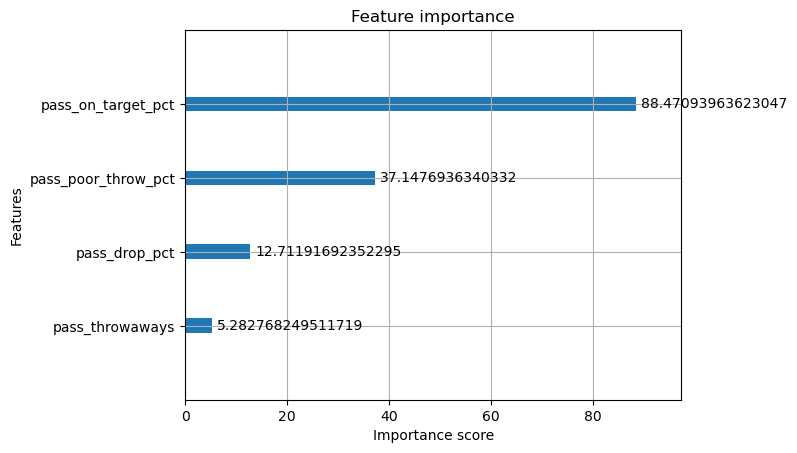

In [157]:
xgb.plot_importance(xgbCmpPct_model, importance_type='gain')  # options: 'weight', 'gain', 'cover'
plt.show()


In [158]:
X.corr()['pass_on_target_pct'].sort_values(ascending=False)


pass_on_target_pct     1.000000
pass_throwaways        0.123860
pass_drop_pct         -0.007616
pass_poor_throw_pct   -0.796520
Name: pass_on_target_pct, dtype: float64

In [159]:
# Create new columns for visuals based on new data from the model

xCmpPct_data['xCmpPct'] = xgbCmpPct_model.predict(X) 

xCmpPct_data['xCmpPctDiff'] = xCmpPct_data['xCmpPct'] - xCmpPct_data['cmpPct'] 


In [160]:
# Filter data to 2024 stats

data24 = xCmpPct_data[xCmpPct_data['Season'] == "2024"]

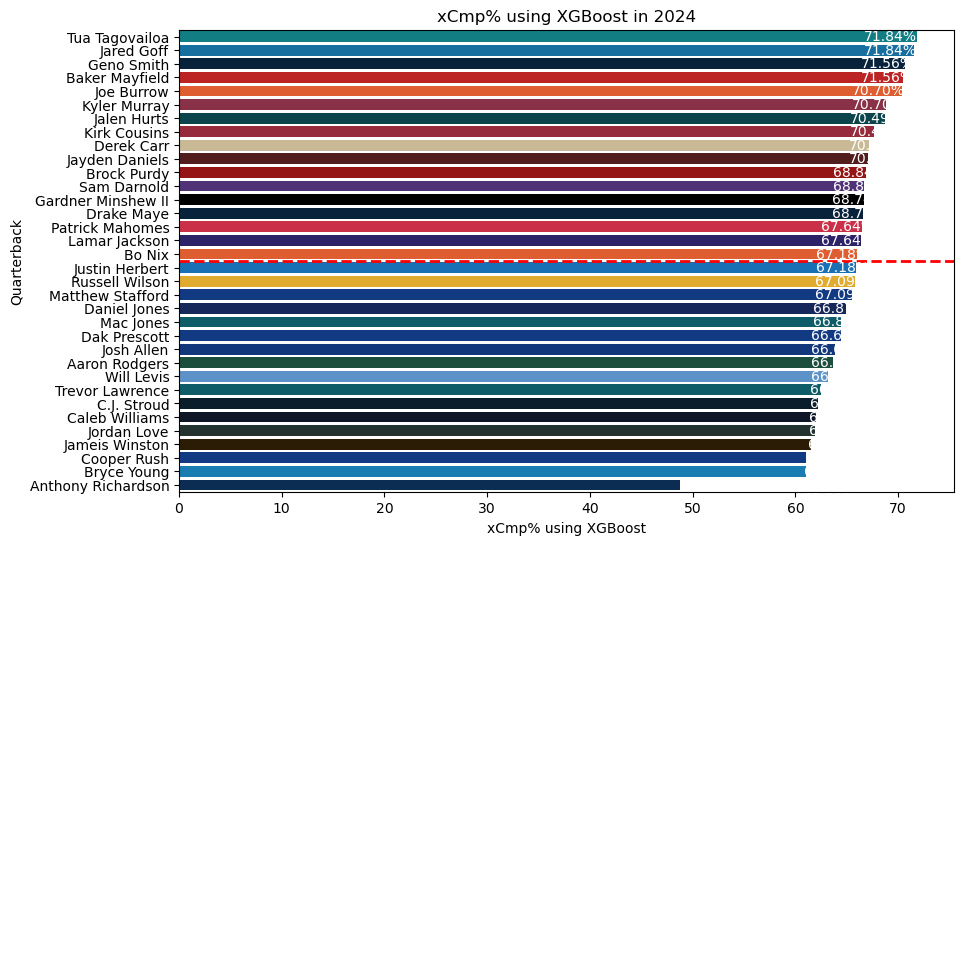

In [161]:
xCmpPct24_graph = statGrapher(data24, 'xCmpPct', 'xCmp% using XGBoost')

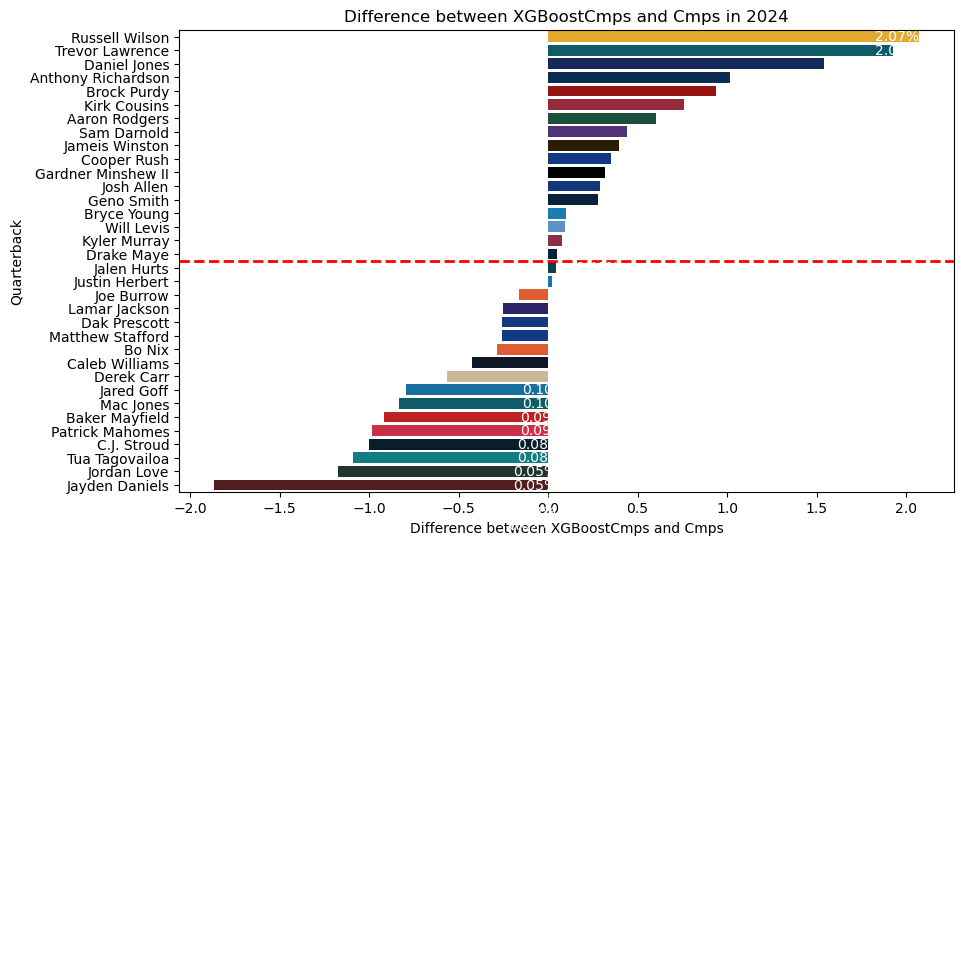

In [162]:
xCmp_diff_graph = statGrapher(data24, 'xCmpPctDiff', 'Difference between XGBoostCmps and Cmps', pct = True)


# xCmp using xgb and raw/proprtional based passing features

In [163]:
# Create X and y

X = xCmp_data[['pass_throwaways', 'pass_poor_throw_pct', 'pass_on_target_pct', 'pass_drop_pct',
              'pass_poor_throws', 'pass_on_target', 'pass_drops']]
y = xCmp_data[['pass_cmp']]

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [165]:
# create xgb model

xgbCmp_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)



In [166]:
xgbCmp_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [167]:
# Get predictions
y_pred = xgbCmp_model.predict(X_test)

y_train_pred = xgbCmp_model.predict(X_train)

In [168]:
# Evaluation Metrics for TESTING data

calcEval(y_test, y_pred)


R²: 0.982525110244751
Mean Absolute Error (MAE): 6.42238187789917
Mean Squared Error (MSE): 82.91200256347656
Root Mean Squared Error (RMSE): 9.105602811647154


In [169]:
# Evaluation Metrics for TRAINING data

calcEval(y_train, y_train_pred)

R²: 0.9977959990501404
Mean Absolute Error (MAE): 2.965766429901123
Mean Squared Error (MSE): 15.139719009399414
Root Mean Squared Error (RMSE): 3.8909791838815346


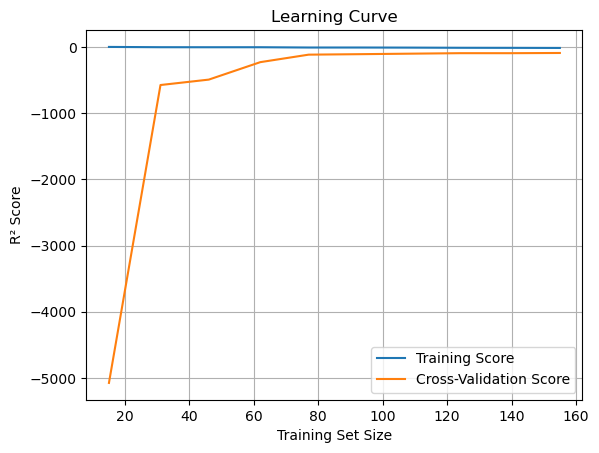

In [170]:
train_sizes, train_scores, test_scores = learning_curve(
    xgbCmp_model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()

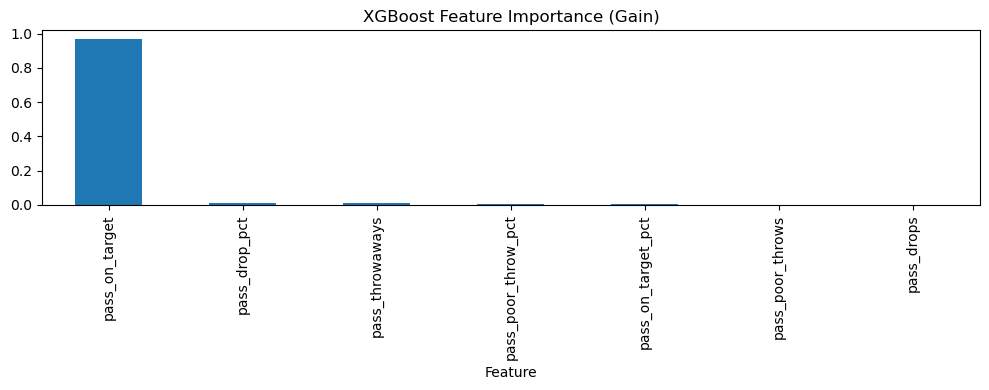

In [171]:
# Plot feature importance

importance = xgbCmp_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
importance_df.plot.bar(x='Feature', y='Importance', legend=False, figsize=(10, 4))
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

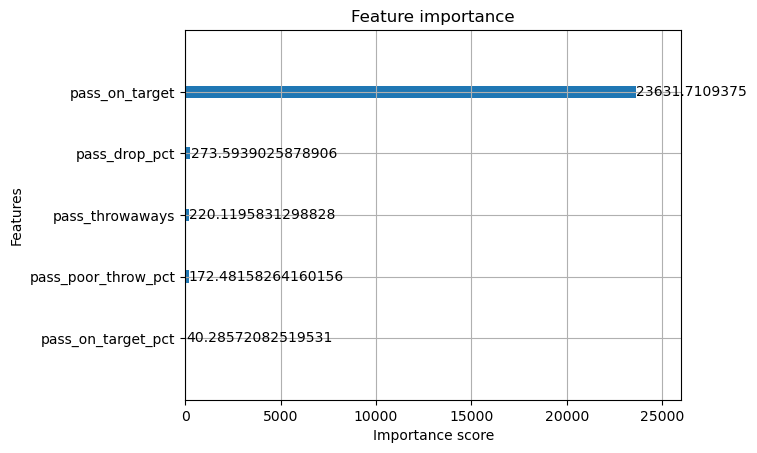

In [172]:
xgb.plot_importance(xgbCmp_model, importance_type='gain')  # options: 'weight', 'gain', 'cover'
plt.show()


In [180]:
X.corr()['pass_on_target'].sort_values(ascending=False)


pass_on_target         1.000000
pass_poor_throws       0.721522
pass_drops             0.717985
pass_on_target_pct     0.429140
pass_throwaways        0.411463
pass_drop_pct          0.085501
pass_poor_throw_pct   -0.261791
Name: pass_on_target, dtype: float64

In [174]:
# Create new columns for visuals based on new data from the model

xCmp_data['xCmp'] = xgbCmp_model.predict(X)

xCmp_data['xCmpPct'] = xCmp_data['xCmp']/xCmp_data['xAtt'] * 100

xCmp_data['xCmpPctDiff'] = xCmp_data['xCmpPct'] - xCmp_data['cmpPct'] 


In [175]:
# Filter data to 2024 stats

data24 = xCmp_data[xCmp_data['Season'] == "2024"]

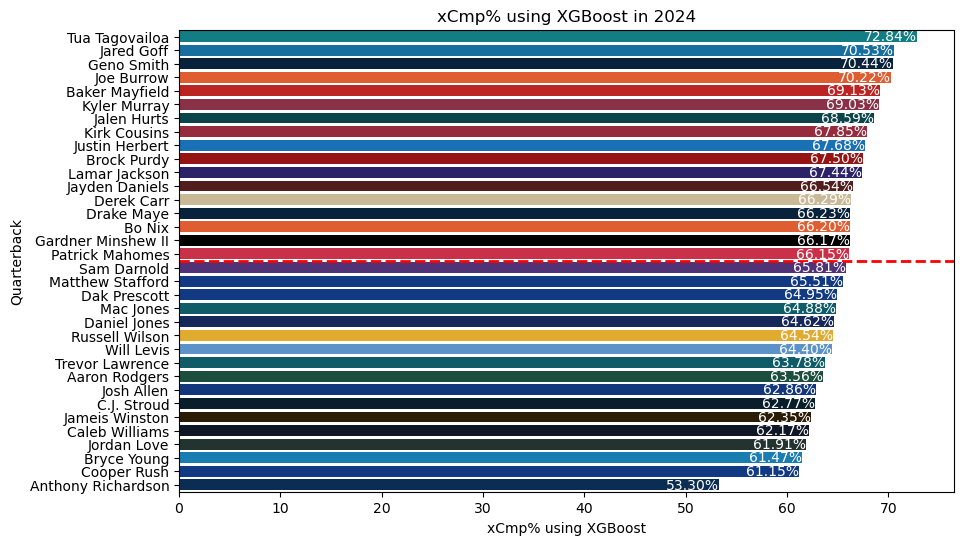

In [176]:
xCmpPct24_graph = statGrapher(data24, 'xCmpPct', 'xCmp% using XGBoost')

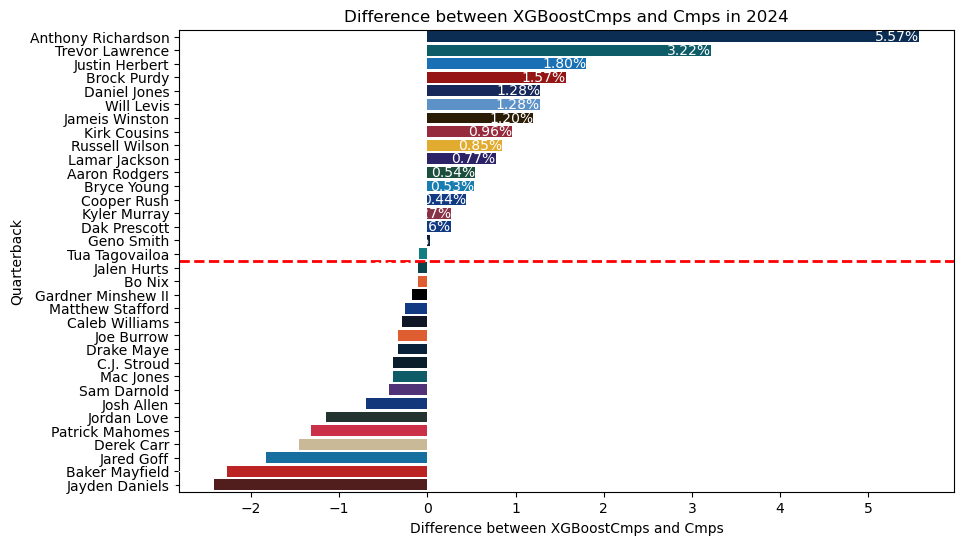

In [177]:
xCmp_diff_graph = statGrapher(data24, 'xCmpPctDiff', 'Difference between XGBoostCmps and Cmps', pct = True)
